In [15]:
import torch
import matplotlib.pyplot as plt
import gym
import numpy as np
from scipy.signal import savgol_filter
import seaborn as sns

from DDPG import DDPGAgent
from DDPG import ReplayBuffer

In [16]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 1 # update target network every this steps
tau = 0.001

episodes = 500    
discount = 0.99
batch_size = 32
exploration_noise = 0.1
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size, 
                  hidden_size=hidden_size, 
                  actor_lr=actor_lr, 
                  critic_lr=critic_lr, 
                  discount=discount, 
                  min_action=min_action,
                  max_action=max_action, 
                  exploration_noise=exploration_noise)

### The RL Training Loop
In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [17]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.act(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        
        # add experience to replay buffer
        # agent.remember(state, action, reward, next_state, done)
        replay_buffer.add((state, next_state, action, reward*reward_scale, done))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    '- Timestep: {}'.format(timesteps),
                    '- Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    '- Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    '- Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    '- Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

Episode: 90 - Timestep: 10171 - Total reward: -202.6 - Episode length: 93.6 - Actor Loss: -0.0656 - Critic Loss: 0.0045
Episode: 100 - Timestep: 11157 - Total reward: -236.6 - Episode length: 98.6 - Actor Loss: -0.0519 - Critic Loss: 0.0034
Episode: 110 - Timestep: 13265 - Total reward: -173.3 - Episode length: 210.8 - Actor Loss: -0.0356 - Critic Loss: 0.0020
Episode: 120 - Timestep: 14885 - Total reward: -205.2 - Episode length: 162.0 - Actor Loss: -0.0256 - Critic Loss: 0.0016
Episode: 130 - Timestep: 16126 - Total reward: -254.2 - Episode length: 124.1 - Actor Loss: -0.0225 - Critic Loss: 0.0014
Episode: 140 - Timestep: 17645 - Total reward: -235.1 - Episode length: 151.9 - Actor Loss: -0.0181 - Critic Loss: 0.0013
Episode: 150 - Timestep: 19215 - Total reward: -225.1 - Episode length: 157.0 - Actor Loss: -0.0162 - Critic Loss: 0.0012
Episode: 160 - Timestep: 20925 - Total reward: -205.3 - Episode length: 171.0 - Actor Loss: -0.0115 - Critic Loss: 0.0010
Episode: 170 - Timestep: 23

/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

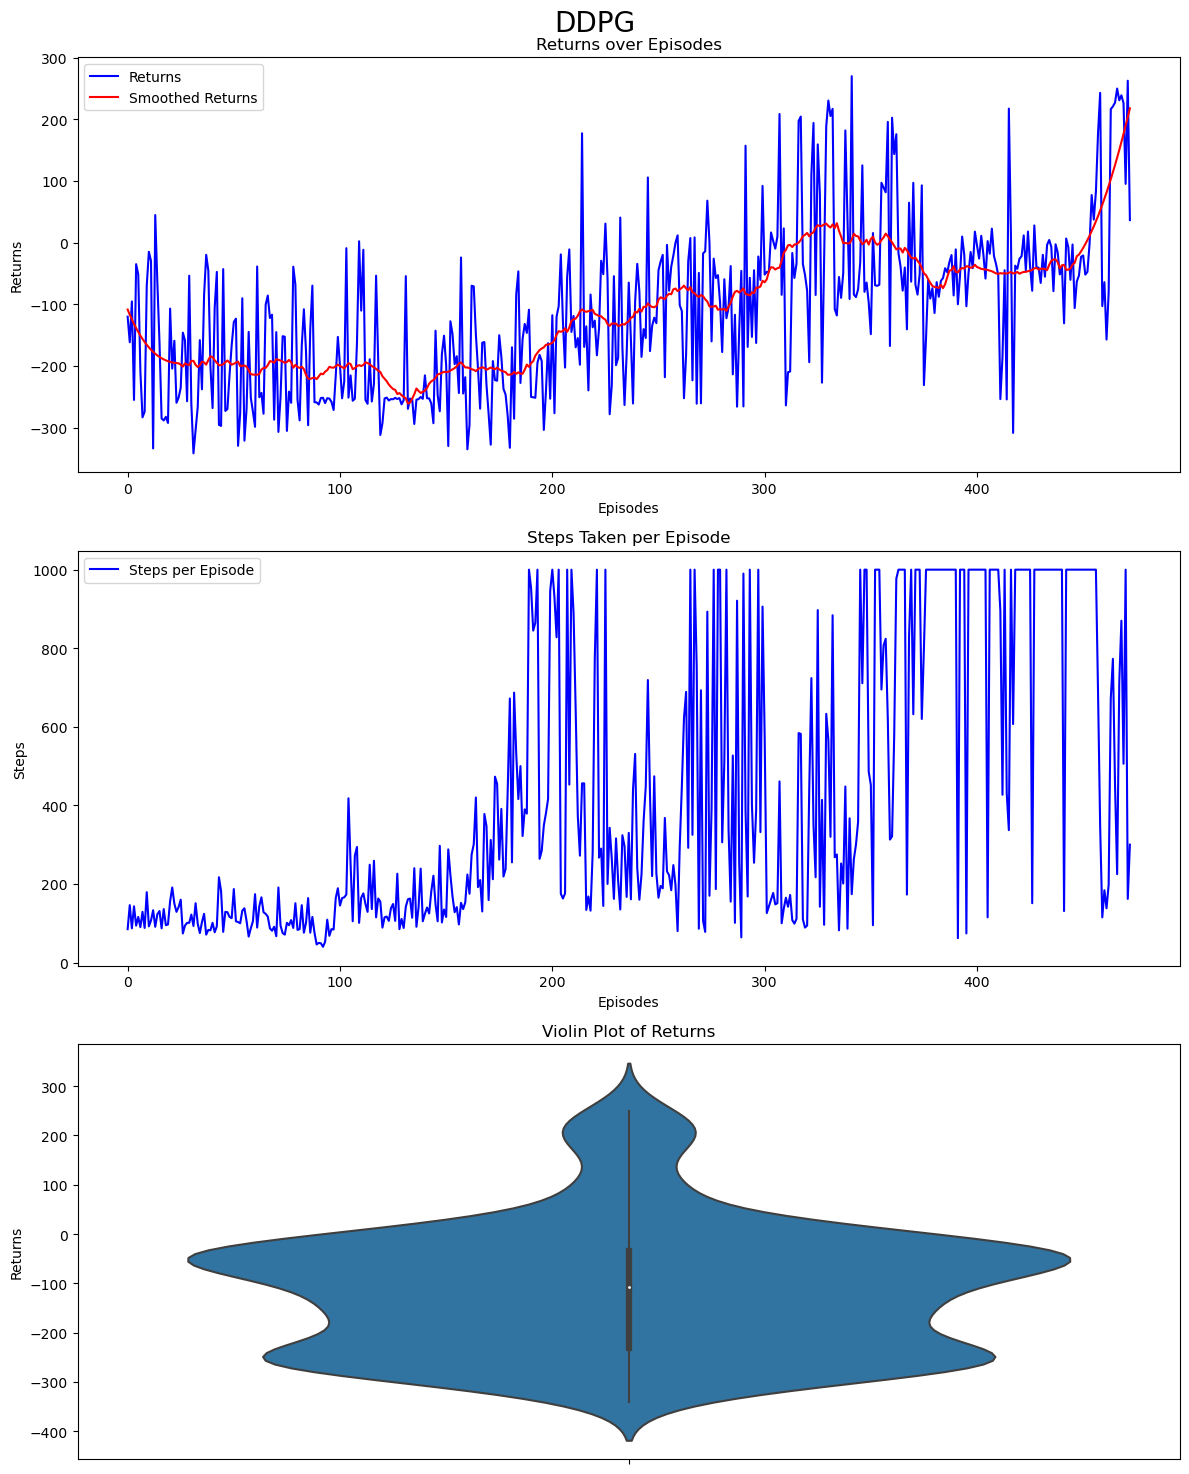

In [20]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, returns, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(reward, 10)
cum_l = get_running_stat(l, 10)


# Determine the window length based on the size of the data
window_length = min(50, len(returns))

# Apply Savitzky-Golay filter
smoothed_returns = savgol_filter(returns, window_length=window_length, polyorder=3)
# MA = pd.Series(returns).rolling(window=100).mean()

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Plot returns and smoothed returns
sns.lineplot(data=returns, label='Returns', color='blue', ax=axs[0])
sns.lineplot(data=smoothed_returns, label='Smoothed Returns', color='red', ax=axs[0])
# sns.lineplot(data=MA, label='Smoothed Returns', color='red', ax=axs[0])
axs[0].set_ylabel('Returns')
axs[0].set_xlabel('Episodes')
axs[0].set_title('Returns over Episodes')
axs[0].legend()

# Plot steps taken per episode
sns.lineplot(x=episode, y=l, label='Steps per Episode', color='blue', ax=axs[1])
axs[1].set_ylabel('Steps')
axs[1].set_xlabel('Episodes')
axs[1].set_title('Steps Taken per Episode')
axs[1].legend()

# Plot violin plot of returns
sns.violinplot(y=returns, ax=axs[2])
axs[2].set_ylabel('Returns')
axs[2].set_title('Violin Plot of Returns')

plt.suptitle('DDPG', fontsize=20)
plt.tight_layout()
plt.show()